In [ ]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

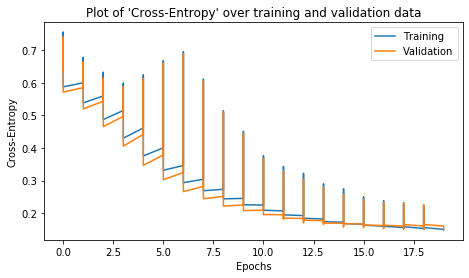

Configuration: 0.25, cross, leaky, leaky, sigmoid, 32
Validation set total error:  0.16074178122496913
Training set total error:  0.1504022941085922
True positives: 40
True negatives: 40
False positives: 1
False negatives: 1
Count correct: 80
Num epochs: 19


In [138]:
import random
import math
import pandas as pd
from sklearn.preprocessing import minmax_scale

class NeuralNetwork:
# loss: cross/mse/msa/kl/huber (https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#id14)
# activation: sigmoid/relu/leaky/elu/hyperbolic (lecture 11, slide 39)
    def __init__(self, num_inputs, num_hidden_1, num_hidden_2, num_outputs, loss_function = "cross", learning_rate=0.5, hidden_layer_1_weights = None, hidden_layer_1_activation = "elu", hidden_layer_1_bias = None, hidden_layer_2_weights = None, hidden_layer_2_activation = "sigmoid", hidden_layer_2_bias = None, output_layer_weights = None, output_layer_activation = "sigmoid", output_layer_bias = None):
        self.num_inputs = num_inputs
        self.loss_function = loss_function
        self.hidden_layer_1 = NeuronLayer(num_hidden_1, loss_function, hidden_layer_1_activation, hidden_layer_1_bias)
        self.hidden_layer_2 = NeuronLayer(num_hidden_2, loss_function, hidden_layer_2_activation, hidden_layer_2_bias)
        self.output_layer = NeuronLayer(num_outputs, loss_function, output_layer_activation, output_layer_bias)
        self.init_weights_from_inputs_to_hidden_layer_1_neurons(hidden_layer_1_weights)
        self.init_weights_from_hidden_layer_1_to_hidden_layer_2_neurons(hidden_layer_2_weights)
        self.init_weights_from_hidden_layer_2_neurons_to_output_layer_neurons(output_layer_weights)
        self.init_bias_from_inputs_to_hidden_layer_1_neurons(hidden_layer_1_bias)
        self.init_bias_from_hidden_layer_1_to_hidden_layer_2_neurons(hidden_layer_2_bias)
        self.init_bias_from_hidden_layer_2_neurons_to_output_layer_neurons(output_layer_bias)
        self.LEARNING_RATE = learning_rate

    def init_weights_from_inputs_to_hidden_layer_1_neurons(self, hidden_layer_1_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer_1.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_1_weights:
                    self.hidden_layer_1.neurons[h].weights.append(random.random()*2-1)
                else:
                    self.hidden_layer_1.neurons[h].weights.append(hidden_layer_1_weights[weight_num])
                weight_num += 1
                self.hidden_layer_1.neurons[h].gradient.append(0)
                
    def init_weights_from_hidden_layer_1_to_hidden_layer_2_neurons(self, hidden_layer_2_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer_2.neurons)):
            for i in range(len(self.hidden_layer_1.neurons)):
                if not hidden_layer_2_weights:
                    self.hidden_layer_2.neurons[h].weights.append(random.random()*2-1)
                else:
                    self.hidden_layer_2.neurons[h].weights.append(hidden_layer_2_weights[weight_num])
                weight_num += 1
                self.hidden_layer_2.neurons[h].gradient.append(0)

    def init_weights_from_hidden_layer_2_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer_2.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random()*2-1)
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1
                self.output_layer.neurons[o].gradient.append(0)
                
    def init_bias_from_inputs_to_hidden_layer_1_neurons(self, hidden_layer_1_bias):
        bias_num = 0
        for h in range(len(self.hidden_layer_1.neurons)):
            if not hidden_layer_1_bias:
                self.hidden_layer_1.neurons[h].bias = random.random()*2-1
            else:
                self.hidden_layer_1.neurons[h].bias = hidden_layer_1_bias[bias_num]
            bias_num += 1
                
    def init_bias_from_hidden_layer_1_to_hidden_layer_2_neurons(self, hidden_layer_2_bias):
        bias_num = 0
        for h in range(len(self.hidden_layer_2.neurons)):
            if not hidden_layer_2_bias:
                self.hidden_layer_2.neurons[h].bias = random.random()*2-1
            else:
                self.hidden_layer_2.neurons[h].bias = hidden_layer_2_bias[bias_num]
            bias_num += 1

    def init_bias_from_hidden_layer_2_neurons_to_output_layer_neurons(self, output_layer_bias):
        bias_num = 0
        for o in range(len(self.output_layer.neurons)):
            if not output_layer_bias:
                self.output_layer.neurons[o].bias = random.random()*2-1
            else:
                self.output_layer.neurons[o].bias = output_layer_bias[bias_num]
            bias_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer 1')
        self.hidden_layer_1.inspect()
        print('------')
        print('Hidden Layer 2')
        self.hidden_layer_2.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_1_outputs = self.hidden_layer_1.feed_forward(inputs)
        hidden_layer_2_outputs = self.hidden_layer_2.feed_forward(hidden_layer_1_outputs)
        return self.output_layer.feed_forward(hidden_layer_2_outputs)

    def train(self, training_sets):
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
            for o in range(len(self.output_layer.neurons)):
                pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])
                # if self.loss_function == "mse" or self.loss_function == "msa":
                pd_errors_wrt_output_neuron_total_net_input[o]/=len(training_sets)
            
            pd_errors_wrt_hidden_2_neuron_total_net_input = [0] * len(self.hidden_layer_2.neurons)
            for h in range(len(self.hidden_layer_2.neurons)):
                d_error_wrt_hidden_2_neuron_output = 0
                for o in range(len(self.output_layer.neurons)):
                    d_error_wrt_hidden_2_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]
                pd_errors_wrt_hidden_2_neuron_total_net_input[h] = d_error_wrt_hidden_2_neuron_output * self.hidden_layer_2.neurons[h].calculate_pd_total_net_input_wrt_input()
            
            pd_errors_wrt_hidden_1_neuron_total_net_input = [0] * len(self.hidden_layer_1.neurons)
            for h in range(len(self.hidden_layer_1.neurons)):
                d_error_wrt_hidden_1_neuron_output = 0
                for o in range(len(self.hidden_layer_2.neurons)):
                    d_error_wrt_hidden_1_neuron_output += pd_errors_wrt_hidden_2_neuron_total_net_input[o] * self.hidden_layer_2.neurons[o].weights[h]
                pd_errors_wrt_hidden_1_neuron_total_net_input[h] = d_error_wrt_hidden_1_neuron_output * self.hidden_layer_1.neurons[h].calculate_pd_total_net_input_wrt_input()
            
            for o in range(len(self.output_layer.neurons)):
                for w_ho in range(len(self.output_layer.neurons[o].weights)):
                    if t == 0:
                        self.output_layer.neurons[o].gradient[w_ho] = 0
                    pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)
                    self.output_layer.neurons[o].gradient[w_ho] += self.LEARNING_RATE * pd_error_wrt_weight
                if t == 0:
                    self.output_layer.neurons[o].bias_gradient = 0
                pd_error_wrt_bias = pd_errors_wrt_output_neuron_total_net_input[o]
                self.output_layer.neurons[o].bias_gradient += self.LEARNING_RATE * pd_error_wrt_bias
            
            for h in range(len(self.hidden_layer_2.neurons)):
                for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                    if t == 0:
                        self.hidden_layer_2.neurons[h].gradient[w_hh] = 0
                    pd_error_wrt_weight = pd_errors_wrt_hidden_2_neuron_total_net_input[h] * self.hidden_layer_2.neurons[h].calculate_pd_total_net_input_wrt_weight(w_hh)
                    self.hidden_layer_2.neurons[h].gradient[w_hh] += self.LEARNING_RATE * pd_error_wrt_weight
                if t == 0:
                    self.hidden_layer_2.neurons[h].bias_gradient = 0
                pd_error_wrt_bias = pd_errors_wrt_hidden_2_neuron_total_net_input[h]
                self.hidden_layer_2.neurons[h].bias_gradient += self.LEARNING_RATE * pd_error_wrt_bias
            
            for h in range(len(self.hidden_layer_1.neurons)):
                for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                    if t == 0:
                        self.hidden_layer_1.neurons[h].gradient[w_ih] = 0
                    pd_error_wrt_weight = pd_errors_wrt_hidden_1_neuron_total_net_input[h] * self.hidden_layer_1.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)
                    self.hidden_layer_1.neurons[h].gradient[w_ih] += self.LEARNING_RATE * pd_error_wrt_weight
                if t == 0:
                    self.hidden_layer_1.neurons[h].bias_gradient = 0
                pd_error_wrt_bias = pd_errors_wrt_hidden_1_neuron_total_net_input[h]
                self.hidden_layer_1.neurons[h].bias_gradient += self.LEARNING_RATE * pd_error_wrt_bias
                    
        for o in range(len(self.output_layer.neurons)):
            self.output_layer.neurons[o].bias -= self.output_layer.neurons[o].bias_gradient
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                self.output_layer.neurons[o].weights[w_ho] -= self.output_layer.neurons[o].gradient[w_ho]
        
        for h in range(len(self.hidden_layer_2.neurons)):
            self.hidden_layer_2.neurons[h].bias -= self.hidden_layer_2.neurons[h].bias_gradient
            for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                self.hidden_layer_2.neurons[h].weights[w_hh] -= self.hidden_layer_2.neurons[h].gradient[w_hh]
            
        for h in range(len(self.hidden_layer_1.neurons)):
            self.hidden_layer_1.neurons[h].bias -= self.hidden_layer_1.neurons[h].bias_gradient
            for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                self.hidden_layer_1.neurons[h].weights[w_ih] -= self.hidden_layer_1.neurons[h].gradient[w_ih]

    def undo(self):
        for o in range(len(self.output_layer.neurons)):
            self.output_layer.neurons[o].bias += self.output_layer.neurons[o].bias_gradient
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                self.output_layer.neurons[o].weights[w_ho] += self.output_layer.neurons[o].gradient[w_ho]
        
        for h in range(len(self.hidden_layer_2.neurons)):
            self.hidden_layer_2.neurons[h].bias += self.hidden_layer_2.neurons[h].bias_gradient
            for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                self.hidden_layer_2.neurons[h].weights[w_hh] += self.hidden_layer_2.neurons[h].gradient[w_hh]
            
        for h in range(len(self.hidden_layer_1.neurons)):
            self.hidden_layer_1.neurons[h].bias += self.hidden_layer_1.neurons[h].bias_gradient
            for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                self.hidden_layer_1.neurons[h].weights[w_ih] += self.hidden_layer_1.neurons[h].gradient[w_ih]

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                error = self.output_layer.neurons[o].calculate_error(training_outputs[o])
                # if self.loss_function == "mse" or self.loss_function == "msa":
                error /= len(training_sets)
                total_error += error
        return total_error
    
    def print_expected_predicted(self, training_sets):
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                print(training_outputs[o], " ",self.output_layer.neurons[o].output)
    
    def count_correct(self, training_sets):
        count = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                if (training_outputs[o] == 1 and self.output_layer.neurons[o].output >= 0.5) or (training_outputs[o] == 0 and self.output_layer.neurons[o].output < 0.5):
                    count+=1
        return count
    
    def true_positive(self, training_sets):
        count = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                if training_outputs[o] == 1 and self.output_layer.neurons[o].output >= 0.5:
                    count+=1
        return count
        
    def true_negative(self, training_sets):
        count = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                if training_outputs[o] == 0 and self.output_layer.neurons[o].output < 0.5:
                    count+=1
        return count
    
    def false_positive(self, training_sets):
        count = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                if training_outputs[o] == 0 and self.output_layer.neurons[o].output >= 0.5:
                    count+=1
        return count
        
    def false_negative(self, training_sets):
        count = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                if training_outputs[o] == 1 and self.output_layer.neurons[o].output < 0.5:
                    count+=1
        return count

class NeuronLayer:
    def __init__(self, num_neurons, loss_function, activation, bias):
        self.loss_function = loss_function
        self.activation = activation
        self.bias = bias if bias else random.random()
        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.loss_function, self.activation, self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, loss_function, activation, bias):
        self.loss_function = loss_function
        self.activation = activation
        self.bias = bias
        self.bias_gradient = 0
        self.weights = []
        self.gradient = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    def squash(self, total_net_input):
        if self.activation == "relu":
            return max(0, total_net_input)
        if self.activation == "sigmoid":
            return 1 / (1 + math.exp(-total_net_input))
        if self.activation == "leaky":
            a = 0.1
            return max(a*total_net_input, total_net_input)
        if self.activation == "elu":
            a = 0.1
            if total_net_input <= 0:
                return a*(math.exp(total_net_input)-1)
            else:
                return total_net_input
        if self.activation == "hyperbolic":
            return math.tanh(total_net_input) # return (math.exp(total_net_input)-math.exp(-total_net_input))/(math.exp(total_net_input)+math.exp(-total_net_input))

    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    def calculate_error(self, target_output):
        if self.loss_function == "mse":
            return (target_output - self.output) ** 2
        if self.loss_function == "cross":
            if target_output == 1:
                return -math.log(self.output)
            else:
                return -math.log(1 - self.output)
        if self.loss_function == "mae":
            return abs(self.output - target_output)
        if self.loss_function == "kl":
            return self.output * math.log(self.output / max(target_output,1e-9))
        if self.loss_function == "huber":
            d = 0.1
            if abs(target_output - self.output) < d:
                return 0.5 * (target_output - self.output) ** 2
            else:
                return d * (target_output - self.output - 0.5 * d)

    def calculate_pd_error_wrt_output(self, target_output):
        if self.loss_function == "mse":
            return - 2 * target_output + 2 * self.output
        if self.loss_function == "cross":
            if target_output == 1:
                return -1/self.output
            else:
                return -1/(self.output-1)
        if self.loss_function == "mae":
            if self.output > target_output:
                return 1
            else:
                return -1
        if self.loss_function == "kl":
            return math.log(self.output / max(target_output,1e-9)) + 1
        if self.loss_function == "huber":
            d = 0.1
            if abs(target_output - self.output) < d:
                return - target_output + self.output
            else:
                return - d

    def calculate_pd_total_net_input_wrt_input(self):
        if self.activation == "relu":
            if self.output >= 0:
                return 1
            else:
                return 0
        if self.activation == "sigmoid":
            return self.output * (1 - self.output)
        if self.activation == "leaky":
            a = 0.1
            if self.output >= 0:
                return 1
            else:
                return a
        if self.activation == "elu":
            a = 0.1
            if self.output <= 0:
                return self.output+a
            else:
                return 1
        if self.activation == "hyperbolic":
            return 1-self.output*self.output

    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

df = pd.read_excel('HW3train.xlsx')
x0 = minmax_scale(df['X_0'].tolist())
x1 = minmax_scale(df['X_1'].tolist())
y = df['y'].tolist()
training_sets = []
for i in range(len(x0)):
    training_sets.append([[x0[i],x1[i]],[y[i]]])

df = pd.read_excel('HW3validate.xlsx')
x0 = minmax_scale(df['X_0'].tolist())
x1 = minmax_scale(df['X_1'].tolist())
y = df['y'].tolist()
validation_sets = []
for i in range(len(x0)):
    validation_sets.append([[x0[i],x1[i]],[y[i]]])

y_train = []
y_eval = []
x_epochs = []
params = [0.25, "cross", "leaky", "leaky", "sigmoid"]

nn = NeuralNetwork(2, 10, 10, 1, learning_rate=params[0], loss_function=params[1], hidden_layer_1_activation=params[2], hidden_layer_2_activation=params[3], output_layer_activation=params[4])
prev_error = 2
error = 1
iteration = 0
epochs = 0
BATCH_SIZE = 32

if BATCH_SIZE > 0:
    while True:
        nn.train(training_sets[BATCH_SIZE*iterations:BATCH_SIZE+BATCH_SIZE*iterations])
        y_train.append(nn.calculate_total_error(training_sets))
        y_eval.append(nn.calculate_total_error(validation_sets))
        x_epochs.append(epochs)
        if nn.calculate_total_error(training_sets) < 0.15:
            break
        iterations += 1
        if iterations % (math.ceil(len(training_sets) / BATCH_SIZE)) == 0:
            iterations = 0
            epochs += 1
else:
    while True:
        nn.train(training_sets)
        error = nn.calculate_total_error(training_sets)
        y_train.append(error)
        y_eval.append(nn.calculate_total_error(validation_sets))
        x_epochs.append(iteration)
        if error < 0.1:
            break
        iteration += 1
        epochs += 1
        if iteration == 1000:
            break
plots("Cross-Entropy")
nn.undo()

print("Configuration: {}, {}, {}, {}, {}, {}".format(params[0], params[1],params[2],params[3],params[4], BATCH_SIZE))
print("Validation set total error: ", nn.calculate_total_error(validation_sets))
print("Training set total error: ", nn.calculate_total_error(training_sets))
# nn.print_expected_predicted(validation_sets)
print("True positives:",nn.true_positive(validation_sets))
print("True negatives:",nn.true_negative(validation_sets))
print("False positives:",nn.false_positive(validation_sets))
print("False negatives:",nn.false_negative(validation_sets))
print("Count correct:",nn.count_correct(validation_sets))
print("Num epochs:", epochs)

In [134]:
def plots(loss_fun: str):
    plt.figure(figsize=(7.5,4))
    plt.plot(x_epochs, y_train, label='Training')
    plt.plot(x_epochs, y_eval, label='Validation')

    plt.xlabel('Epochs')
    plt.ylabel(loss_fun)

    plt.title("Plot of '{}' over training and validation data".format(loss_fun))

    plt.legend()
    plt.savefig('fig1.png', dpi = 300)
    plt.show()